In [801]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from math import ceil
import matplotlib.pyplot as plt
from matplotlib import ticker
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Data

## Load and preprocess data

In [802]:
DATA_PATH = './data/'

In [803]:
# Load and preprocess data

numerical_features = ['age', 'sibsp', 'parch', 'fare']
categorical_features = ['pclass', 'sex', 'embarked']

def read_csv(type = 'train') :
    dataset = pd.read_csv('{}/{}.csv'.format(DATA_PATH, type))
    dataset.columns = dataset.columns.str.lower()
    
    return dataset

def get_training_features_labels() :
    training_data = read_csv('train')
    
    X_train = training_data.drop(columns=['survived'])
    X_train = X_train[numerical_features + categorical_features]
    
    y_train = training_data['survived']
    
    return X_train, y_train

def get_preprocessor(scaler = 'standard') :
    numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ]
    )
    
    if scaler == 'standard' :
        numerical_transformer.steps.append(['scaler', StandardScaler()])
    if scaler == 'minmax' :
        numerical_transformer.steps.append(['scaler', MinMaxScaler()])

    categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]
        )

    preprocessor = ColumnTransformer([
        ('numerical_transformer', numerical_transformer, numerical_features),
        ('categorical_transformer', categorical_transformer, categorical_features)
    ])
    
    return preprocessor

X_train, y_train = get_training_features_labels()
preprocessor = get_preprocessor(scaler='standard')

X_train = preprocessor.fit_transform(X_train)

X_test = read_csv('test')
X_test = preprocessor.transform(X_test)

## Visualize data

In [804]:
# Load preprocessed dataframe from X_train, y_train and a raw dataframe without changes

X_df = pd.DataFrame(X_train, columns=[x[(x.find('_', x.find('_') + 1)) + 2:] for x in preprocessor.get_feature_names_out()])
y_df = pd.DataFrame(y_train, columns=['survived'])

df_preprocessed = pd.DataFrame.join(X_df, y_df)
df_raw = read_csv('train')

In [805]:
# Visualize raw data

display(df_raw.head())
display(df_raw.describe())

print('{}\n'.format(train_data_raw['embarked'].value_counts()))
print('{}\n'.format(train_data_raw['sex'].value_counts()))

for column in train_data_raw :
    null_count = train_data_raw[column].isna().sum()
    
    if null_count > 0 :
        print("Amount of null values in {} column: {} ({:.3f}%)".format(column, null_count, null_count/len(train_data_raw)))

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


embarked
S    644
C    168
Q     77
Name: count, dtype: int64

sex
male      577
female    314
Name: count, dtype: int64

Amount of null values in age column: 177 (0.199%)
Amount of null values in cabin column: 687 (0.771%)
Amount of null values in embarked column: 2 (0.002%)


In [806]:
# Visualize correlation matrix

df_preprocessed_corr_matrix = df_preprocessed.corr()['survived'].sort_values(ascending=False)

print('Preprocessed DF Correlation Matrix\n{}'.format(df_preprocessed_corr_matrix))

Preprocessed DF Correlation Matrix
survived      1.000000
sex_female    0.543351
pclass_1      0.285904
fare          0.257307
embarked_C    0.168240
pclass_2      0.093349
parch         0.081629
embarked_Q    0.003650
sibsp        -0.035322
age          -0.064910
embarked_S   -0.149683
pclass_3     -0.322308
sex_male     -0.543351
Name: survived, dtype: float64


In [807]:
def plot_stacked_bar(x, y1, y2, y1label = 'y1', y2label = 'y2', title = '', xlabel = '', ylabel = '', 
                     using_percentage = True, major_locator_range = -1, 
                     yaxis_visibility = False, xaxis_visibility = True,
                     xticks = [], yticks = [], figsize=(10, 8)) :
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.bar(x, y1, color='cornflowerblue', edgecolor='dimgray', label=y1label, width=5)
    ax.bar(x, y2, bottom=y1, color='indianred', edgecolor='dimgray', label=y2label, width = 5)

    for c in ax.containers :
        if using_percentage :
            ax.bar_label(c, label_type='center', fmt='%.3f%%')
        else :
            ax.bar_label(c, label_type='center')
    
    if major_locator_range > 0 :
        ax.xaxis.set_major_locator(ticker.MultipleLocator(major_locator_range))
    
    ax.get_yaxis().set_visible(yaxis_visibility)
    ax.get_xaxis().set_visible(xaxis_visibility)
    
    if title != '' :
        ax.set_title(title)
        
    if xlabel != '' :
        ax.set_xlabel(xlabel)
        
    if ylabel != '' :
        ax.set_xlabel(ylabel)

    if xticks != [] :
        ax.set_xticks(x, xticks)
        
    if yticks != [] :
        ax.set_yticks(x, yticks)
     
    plt.legend()
    plt.show()

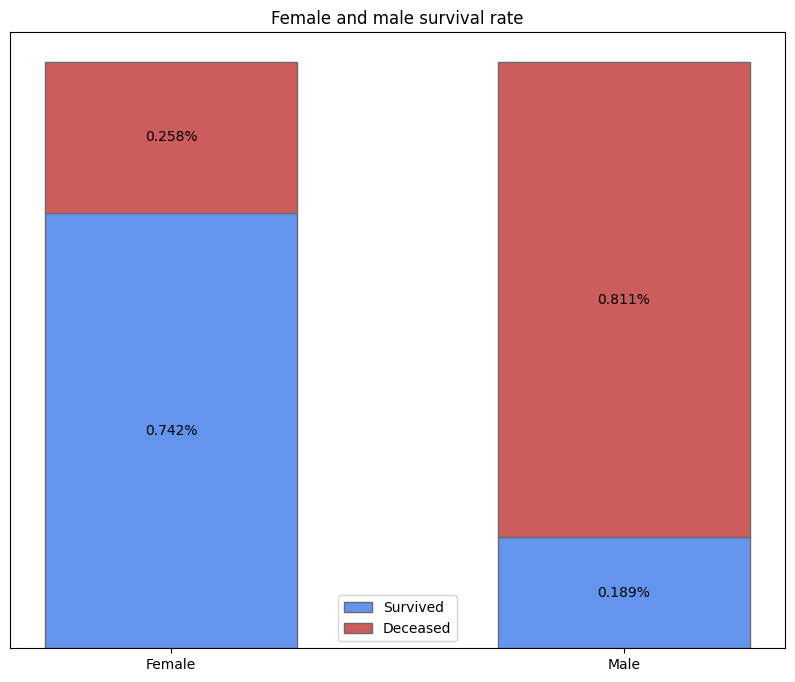

In [808]:
# Female and male survival rate comparison

def plot_female_male_survival() :
    female = df_preprocessed.loc[df_preprocessed['sex_female'] == 1]
    male = df_preprocessed.loc[df_preprocessed['sex_male'] == 1]

    female_survivor_count = len(female.loc[female['survived'] == 1])
    female_deceased_count = len(female.loc[female['survived'] == 0])
    
    male_survivor_count = len(male.loc[male['survived'] == 1])
    male_deceased_count = len(male.loc[male['survived'] == 0])

    x = [
        (1),
        (10)
    ]

    y1 = [
        (female_survivor_count / (len(female))),
        (male_survivor_count / (len(male)))
    ]
    
    y2 = [
        (female_deceased_count / (len(female))),
        (male_deceased_count / (len(male))),
    ]
    
    plot_stacked_bar(x, y1, y2, title='Female and male survival rate', y1label='Survived', y2label='Deceased', xaxis_visibility=True, xticks=['Female', 'Male'])
      
plot_female_male_survival()

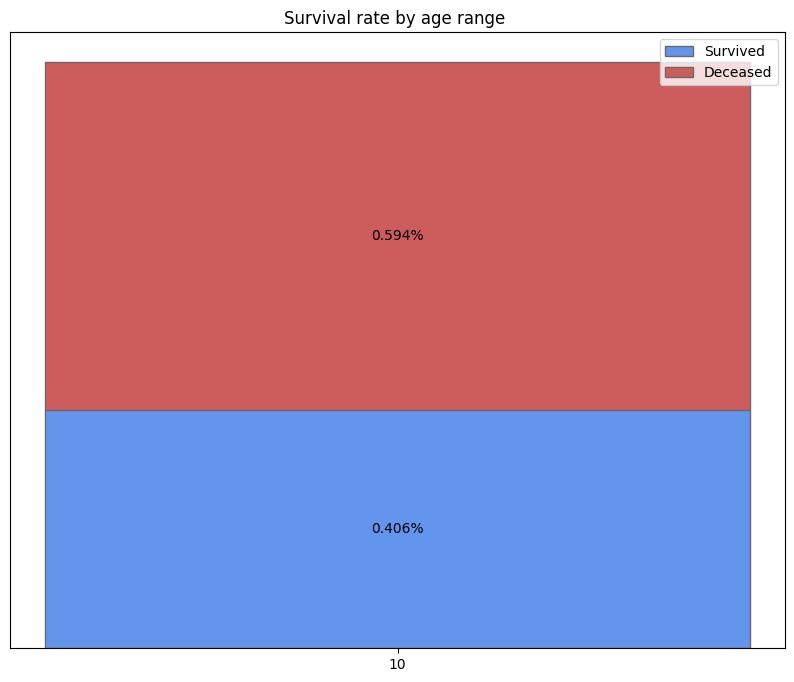

In [809]:
# Age distribution among survivors and deceased

def plot_age_range_survival() :
    age_range = 10

    using_percentage = True

    x = []
    y1 = []
    y2 = []

    age_survived = df_preprocessed[['age', 'survived']].sort_values(by='age')
    step = 1
    interval = [0]
    while len(interval) > 0 :        
        interval = age_survived.loc[(age_survived['age'] > age_range * (step - 1)) & (age_survived['age'] <= age_range * step)]
        
        if len(interval) == 0 : 
            break
        
        total = len(interval)
        survivors = len(interval.loc[interval['survived'] == 1])
        deceased = len(interval.loc[interval['survived'] == 0])
        
        x.append(age_range * step)
        y1.append(survivors / total if using_percentage else survivors)
        y2.append(deceased / total if using_percentage else deceased)
        
        step += 1

    plot_stacked_bar(x, y1, y2, y1label='Survived', y2label='Deceased', title='Survival rate by age range ', using_percentage=using_percentage, major_locator_range=age_range, figsize=(10, 8))
    
plot_age_range_survival()

# Models

## Training

In [810]:
def fit_predict_model(X_train, y_train, model, folds = 3, model_name = '', output_cross_val_scores = True) :
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=folds)
    
    if output_cross_val_scores :
        if model_name != '' :
            print(model_name)
        
        print("Scores: {}".format(scores))
        print("Mean: {}".format(scores.mean()))
        print("Std: {}\n".format(scores.std()))

In [811]:
# KNN

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
fit_predict_model(X_train, y_train, knn, folds=5, model_name='KNN')

KNN
Scores: [0.75418994 0.76966292 0.83707865 0.80898876 0.83707865]
Mean: 0.8013997865796247
Std: 0.034174707746765134



In [816]:
# Random Forest

rf = RandomForestClassifier(n_estimators=1442, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=None, bootstrap=False)
fit_predict_model(X_train, y_train, rf, folds=5, model_name='Random Forest')

Random Forest
Scores: [0.80446927 0.80337079 0.88764045 0.80898876 0.85393258]
Mean: 0.831680371602536
Std: 0.0337149129850529



In [813]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
fit_predict_model(X_train, y_train, decision_tree, folds=5, model_name='Decision Tree')

Decision Tree
Scores: [0.77094972 0.78089888 0.81460674 0.73595506 0.8258427 ]
Mean: 0.7856506182913816
Std: 0.03213161860855321



In [814]:
# Linear SVC

X_train_custom, y_train_custom = get_training_features_labels()
preprocessor = get_preprocessor(scaler='minmax')
X_train_custom = preprocessor.fit_transform(X_train_custom, y_train)

linear_svc = LinearSVC(C=0.2, loss='hinge', max_iter=20000, dual='auto')
fit_predict_model(X_train_custom, y_train, linear_svc, folds=5, model_name='Linear SVC')

Linear SVC
Scores: [0.80446927 0.80337079 0.78651685 0.75280899 0.78651685]
Mean: 0.7867365513778168
Std: 0.018667207932566335



c:\Users\Lucas\miniconda3\envs\tf\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
